In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
import gym
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import random
from collections import deque
import sys
import matplotlib.pyplot as plt
import copy

In [2]:
class Actor(nn.Module):
    
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)

        self.max_action = max_action


    def forward(self, x):
#         x = x.view(x.size(0), -1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.max_action * torch.tanh(self.l3(x)) 
        return x
    
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)


    def forward(self, x, u):
        xu = torch.cat([x, u], 1)

        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xu))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)
        return x1, x2


    def Q1(self, x, u):
        xu = torch.cat([x, u], 1)
        xu = xu.view(xu.size(0), -1)
        x1 = F.relu(self.l1(xu))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)
        return x1



In [3]:
class Buffer:
    def __init__(self):
        self.Memory = []
        
    def add(self, state, action, reward, next_state, done):
        step = (state, action, reward, next_state, done)
        self.Memory.append(step)
    
    def get_mini_batch(self, batch_size):
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        
        batch = random.sample(self.Memory, batch_size)
        for state, action, reward, next_state, done in batch:
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        
        return states, actions, rewards, next_states, dones
    
    def get_size(self):
        return len(self.Memory)

In [4]:
class Agent:
    def __init__(self, env, max_action, actor_alpha = 1e-3, critic_alpha = 1e-3 ,gamma = 0.99, tau = 0.005, noise_c = 1.0, d = 2, sigma = 1, batch_size = 100):
        self.env = env
        self.batch_size = batch_size
        self.noise_c = noise_c
        self.actor_alpha = actor_alpha
        self.critic_alpha = critic_alpha
        self.max_action = max_action
        self.d = d
        self.tau = tau
        self.gamma = gamma 
        self.sigma = sigma
        self.current_state = None
        
        #Actor Network
        self.actor = Actor(env.observation_space.shape[0], env.action_space.shape[0], self.max_action)
        self.actor_target = copy.deepcopy(self.actor)
        self.act_opt = optim.Adam(self.actor.parameters(), lr=actor_alpha)
        
        #Critic Network
        self.critic = Critic(env.observation_space.shape[0], env.action_space.shape[0])
        self.critic_target = copy.deepcopy(self.critic)
        self.crit_opt = optim.Adam(self.critic.parameters(), lr=critic_alpha)
        
        #Relay Buffer
        self.replay_buffer = Buffer()
        
    def step(self, time_step):
        action = self.actor.forward(torch.FloatTensor(self.current_state))
        action = (action.detach().numpy().flatten() + np.random.normal(0, self.sigma, self.env.action_space.shape[0]))
        action.clip(self.env.action_space.low, self.env.action_space.high)
        #print(action)
        next_state, reward, done, _ = env.step(action)
        self.current_state = next_state
        self.replay_buffer.add(self.current_state, action, reward, next_state, done)
        if self.replay_buffer.get_size() > self.batch_size:
            self.update(time_step)
        if done is True:
            done, state = False, self.env.reset()
            return reward, True
        return reward, done
   

    def update(self, time_step):
        states, actions, rewards, next_states, dones = self.replay_buffer.get_mini_batch(self.batch_size) 
        
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        next_states = torch.FloatTensor(next_states)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(1-np.array(dones))
        next_actions = self.actor_target.forward(next_states)
        #print(next_actions.detach().numpy().shape)
        
        noise = torch.FloatTensor(actions).data.normal_(0, 1) #tensor of size BATCH_SIZE x ACTION_SIZE
        noise = noise.clamp(-self.noise_c, self.noise_c)
#         print(type(noise), noise.shape)
        next_actions = (next_actions + noise).clamp(-self.max_action, self.max_action)
        #print(next_states.shape, next_actions.shape)
        #update critic
        q_1, q_2 = self.critic_target.forward(next_states, next_actions)
        y = rewards + (self.gamma * torch.min(q_1, q_2)).detach()
        
        current_q1, current_q2 = self.critic.forward(states, actions)
        loss_c = F.mse_loss(y, current_q1) + F.mse_loss(y, current_q2)
        
        self.crit_opt.zero_grad()
        loss_c.backward()
        self.crit_opt.step()
        
        if time_step % self.d == 0:
            #update actor
            action = self.actor.forward(states)
            loss_a = -self.critic.Q1(states, action).mean() #compute loss
            self.act_opt.zero_grad()
            loss_a.backward()
            
            self.act_opt.step()
            self.target_update(self.critic, self.critic_target)
            self.target_update(self.actor, self.actor_target)

    def target_update(self, model, model_target):
        for theta, theta_ in zip(model.parameters(), model_target.parameters()):
            update = self.tau * theta + (1 - self.tau)*theta_
            theta_.data.copy_(update)
            
    def run_episode(self, current_state):
        self.current_state = current_state
        episode_done = False
        self.env.render() #start the episode
        rewards = []
        timesteps = 0
        for timesteps in range(100)
            reward, episode_done = self.step(timesteps)
            avg_rewards.append(reward)
            if episode_done is True:
                break

        return rewards
        
        

In [5]:
env = gym.make('BipedalWalker-v2')
current_state = env.reset()
env.observation_space.shape[0] + env.action_space.shape[0]

28

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 0 avg reward nan
Episode 1 avg reward nan
Episode 2 avg reward nan
Episode 3 avg reward nan
Episode 4 avg reward nan
Episode 5 avg reward nan
Episode 6 avg reward nan
Episode 7 avg reward nan
Episode 8 avg reward nan
Episode 9 avg reward nan
Episode 10 avg reward nan
Episode 11 avg reward nan
Episode 12 avg reward nan
Episode 13 avg reward nan
Episode 14 avg reward nan
Episode 15 avg reward nan
Episode 16 avg reward nan
Episode 17 avg reward nan
Episode 18 avg reward nan
Episode 19 avg reward nan
Episode 20 avg reward nan
Episode 21 avg reward nan
Episode 22 avg reward nan
Episode 23 avg reward nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode 24 avg reward nan
Episode 25 avg reward nan
Episode 26 avg reward nan
Episode 27 avg reward nan
Episode 28 avg reward nan
Episode 29 avg reward nan
Episode 30 avg reward nan
Episode 31 avg reward nan
Episode 32 avg reward nan
Episode 33 avg reward nan
Episode 34 avg reward nan
Episode 35 avg reward nan
Episode 36 avg reward nan
Episode 37 avg reward nan
Episode 38 avg reward nan
Episode 39 avg reward nan
Episode 40 avg reward nan
Episode 41 avg reward nan
Episode 42 avg reward nan
Episode 43 avg reward nan
Episode 44 avg reward nan
Episode 45 avg reward nan
Episode 46 avg reward nan
Episode 47 avg reward nan
Episode 48 avg reward nan
Episode 49 avg reward nan


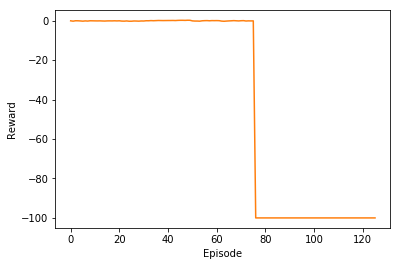

In [6]:
rewards = []
avg_rewards = []
max_action = float(env.action_space.high[0])
BATCH_SIZE = 100
GAMMA = 0.99
TAU = 0.005
NOISE = 0.2
NOISE_CLIP = 0.5
EXPLORE_NOISE = 0.1
rewards = []
env.observation_space.shape[0]
agent = Agent(env, max_action)
for episode in range(50):
    
    episode_rewards = agent.run_episode(current_state)
    
    print('Episode '+str(episode) + " avg reward "+ str(np.mean(episode_rewards)))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [7]:
env.close()